<a href="https://colab.research.google.com/github/jazbengu/COS711-ASSIGNMENT-TWO/blob/main/Joy_Bengu_25000307_COS711_Assignment_Two_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install scikeras
!pip install --force-reinstall tensorflow
!pip install --force-reinstall keras



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached ml_dtypes-0.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached packaging-24.1-py3-none-any.whl.metadata (3.2 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadat

  Using cached keras-2.11.0-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.6.0
    Uninstalling keras-3.6.0:
      Successfully uninstalled keras-3.6.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 455, in run
    installed = install_given_reqs(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/__init__.py", line 70, in install_given_reqs
    requirement.install(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_install.py", line 851, in install
    install_wheel(
  File "/usr

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers import Optimizer
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt




ImportError: cannot import name 'distribute' from partially initialized module 'keras' (most likely due to a circular import) (/usr/local/lib/python3.10/dist-packages/keras/__init__.py)

In [45]:

def load_data(file_path):
    data = pd.read_csv(file_path)
    imputer = SimpleImputer(strategy='mean')
    data.iloc[:, :-1] = imputer.fit_transform(data.iloc[:, :-1])  # Assuming last column is labels

    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    y = pd.get_dummies(y).values

    return X, y

def preprocess_data(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test


In [52]:
class RProp(Optimizer):
    def __init__(self, learning_rate=0.01, eta_plus=1.2, eta_minus=0.5,
                 delta_min=1e-6, delta_max=50, **kwargs):

        # Pass learning_rate to superclass
        kwargs['learning_rate'] = learning_rate
        super(RProp, self).__init__(**kwargs)

        self.eta_plus = eta_plus
        self.eta_minus = eta_minus
        self.delta_min = delta_min
        self.delta_max = delta_max

        # Initialize step sizes for each parameter
        self._step_sizes = {}
        self.eta_plus = eta_plus
        self.eta_minus = eta_minus
        self.delta_min = delta_min
        self.delta_max = delta_max
        self._delta_zero = K.constant(0.1)


    def _resource_apply_dense(self, grad, var):
        # This is a basic implementation, and might need to be adapted
        # depending on your specific use case and TensorFlow version.

        # Get the update operation from the get_updates method
        update_op = self.get_updates(None, [var])[0]  # Assuming only one variable

        # Execute the update operation
        self._distribution_strategy.extended.update(
            var, lambda: update_op, group=False
        )

    def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
        # Get step size for the variable
        step_size = self.get_slot(var, 'step_size')

        # Gather relevant step sizes based on indices
        gathered_step_sizes = tf.gather(step_size, indices)

        # Calculate updates
        updates = -K.sign(grad) * gathered_step_sizes

        # Apply updates to the variable
        var.assign(tf.tensor_scatter_nd_update(var, tf.expand_dims(indices, axis=-1), updates))

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        shapes = [K.int_shape(p) for p in params]
        deltas = [K.zeros(shape) for shape in shapes]
        grad_prevs = [K.zeros(shape) for shape in shapes]

        for p, g, delta, grad_prev in zip(params, grads, deltas, grad_prevs):
            change = K.sign(g * grad_prev)

            new_delta = K.switch(
                K.equal(change, 1),
                K.minimum(delta * self.eta_plus, self.delta_max),
                K.switch(
                    K.equal(change, -1),
                    K.maximum(delta * self.eta_minus, self.delta_min),
                    self._delta_zero
                )
            )

            update = -K.sign(g) * new_delta

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                update = p.constraint(update)

            self.updates.append(K.update(p, p + update))
            self.updates.append(K.update(delta, new_delta))
            self.updates.append(K.update(grad_prev, g))

        return self.updates

    def get_config(self):
        config = super(RProp, self).get_config()
        config.update({
            'learning_rate': self.learning_rate,
            'eta_plus': self.eta_plus,
            'eta_minus': self.eta_minus,
            'delta_min': self.delta_min,
            'delta_max': self.delta_max
        })
        return config


In [47]:


def create_model(optimizer='adam', learning_rate=0.001, activation='relu'):
    model = Sequential()
    model.add(Dense(128, input_dim=13, activation=activation))  # 12 input features
    model.add(Dense(64, activation=activation))
    model.add(Dense(3, activation='softmax'))  # 3 classes

    # Initialize the optimizer based on the chosen or default optimizer type
    if optimizer == 'adam':
        # Providing a default learning rate for Adam if not specified
        learning_rate = learning_rate or 0.001
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        # Providing a default learning rate for SGD if not specified
        learning_rate = learning_rate or 0.001
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'rprop':  # Use RProp Optimizer
       opt = RProp(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer type")

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


In [48]:
from scikeras.wrappers import KerasClassifier
def perform_grid_search(X_train, y_train):
    model = KerasClassifier(build_fn=create_model, verbose=0)
    param_grid = {
        'batch_size': [5, 10, 20],
        'epochs': [5, 10]
    }

    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(X_train, y_train)

    print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

    # Plotting results
    results_df = pd.DataFrame(grid_result.cv_results_)
    results_pivot = results_df.pivot_table(index='param_batch_size', columns='param_epochs', values='mean_test_score')

    plt.figure(figsize=(8, 6))
    sns.heatmap(results_pivot, annot=True, fmt=".3f", cmap="YlGnBu")
    plt.title("Hyperparameter Tuning: Batch Size vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Batch Size")
    plt.show()

    return grid_result.best_estimator_

In [49]:
def train_and_compare_algorithms(X_train, y_train, X_test, y_test):
    adam_model = create_model(optimizer='adam', learning_rate=0.001)
    history_adam = adam_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=20)

    sgd_model = create_model(optimizer='sgd', learning_rate=0.001)
    history_sgd = sgd_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=20)

    rprop_model = create_model(optimizer='rprop', learning_rate=0.001)
    history_rprop = rprop_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=20)

    plt.plot(history_adam.history['val_loss'], label='Adam')
    plt.plot(history_sgd.history['val_loss'], label='SGD')
    plt.plot(history_rprop.history['val_loss'], label='Rprop')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.show()



In [50]:
def hybrid_learning(X_train, y_train, X_test, y_test):
    # Train individual models
    adam_model = create_model(optimizer='adam', learning_rate=0.001)
    adam_model.fit(X_train, y_train, epochs=20, batch_size=20, verbose=0)

    sgd_model = create_model(optimizer='sgd', learning_rate=0.001)
    sgd_model.fit(X_train, y_train, epochs=20, batch_size=20, verbose=0)

    rprop_model = create_model(optimizer='rprop')
    rprop_model.fit(X_train, y_train, epochs=20, batch_size=20, verbose=0)

    # Ensemble predictions by averaging
    adam_pred = adam_model.predict(X_test)
    sgd_pred = sgd_model.predict(X_test)
    rprop_pred = rprop_model.predict(X_test)

    # Average predictions from the models
    ensemble_pred = (adam_pred + sgd_pred + rprop_pred) / 3
    ensemble_pred = np.argmax(ensemble_pred, axis=1)  # Assuming classification

    y_test_labels = np.argmax(y_test, axis=1)  # Get true labels
    accuracy = np.mean(ensemble_pred == y_test_labels)

    print(f"Ensemble model accuracy: {accuracy}")


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best: 0.9589618127888858 using {'batch_size': 5, 'epochs': 10}


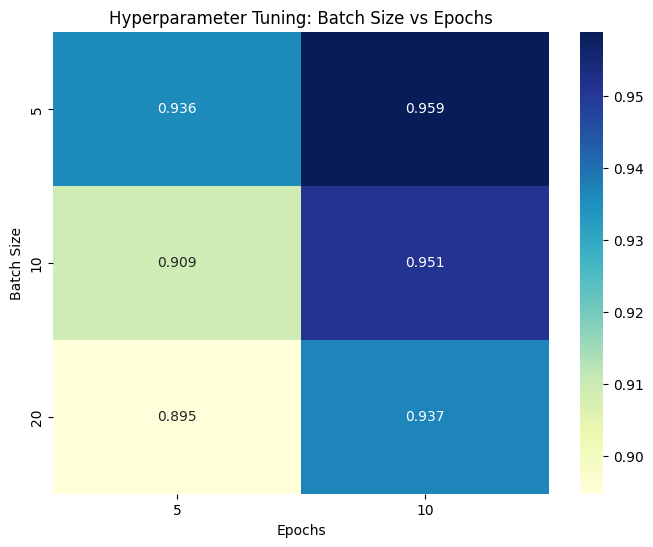

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6230 - loss: 0.8423 - val_accuracy: 0.7914 - val_loss: 0.5474
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7901 - loss: 0.5515 - val_accuracy: 0.8538 - val_loss: 0.4323
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8497 - loss: 0.4332 - val_accuracy: 0.8841 - val_loss: 0.3467
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8684 - loss: 0.3629 - val_accuracy: 0.8984 - val_loss: 0.2884
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9182 - loss: 0.2573 - val_accuracy: 0.9162 - val_loss: 0.2335
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9289 - loss: 0.2325 - val_accuracy: 0.9287 - val_loss: 0.2176
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9491 - loss: 0.1757 - val_accuracy: 0.9394 - val_loss: 0.1660
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9460 - loss: 0.1523 - val_accuracy: 0.9109 - val_

NotImplementedError: 

In [53]:
def main():
    X, y = load_data('Almond.csv')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_test = preprocess_data(X_train, X_test)

    best_model = perform_grid_search(X_train, y_train)
    train_and_compare_algorithms(X_train, y_train, X_test, y_test)
    hybrid_learning(X_train, y_train, X_test, y_test)

if __name__ == "__main__":
    main()